In [1]:
#instal libraries

#pip install sentence-transformers
#pip install umap-learn
#pip install hdbscan

In [1]:
#import libraries

import re
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#reads in california constitution

#i need to clean the data more

with open('/Users/jianingcai/Documents/GitHub/DS4002-Project1/DATA/2011.txt', 'r') as f:
    data = f.read()

In [3]:
data

'          HARRY POTTER AND THE DEATHLY HALLOWS - PART 2\n\n\n\n                               by\n\n                    screenplay Steve Kloves\n\n\n\n               Based on the novel by J.K. Rowling\n\n\n\n\n      This script is the confidential and proprietary\n      property of Warner Bros. Pictures and no portion of\n      it may be performed, distributed, reproduced, used,\n      quoted or published without prior written permission.\n\n\n\n\n                                           (Draft 09-09-09 with\n                                           Interim Revisions to\n                                           date)\n\n                                           December 14, 2010\nWarner Bros. Prod. Ltd.                    © 2010\n4000 Warner Boulevard                      WARNER BROS. ENT.\nBurbank, California 91522                  All Rights Reserved\n\x0c        FADE IN:\n\nA162-E162 OMITTED                                           A162-E162\n\nE162A   Out of SHIFTING DARKN

In [4]:
#data cleaning

def clean(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, ' ', text)

data = clean(data)
data = data.replace('SEC.', ' ')

In [5]:
#Removes all numbers
data = ''.join([i for i in data if not i.isdigit()])

In [6]:
data = data.split("\n")    

In [7]:
data = [item for item in data if item != '']

In [8]:
data

['          HARRY POTTER AND THE  DEATHLY HALLOWS - PART ',
 '                               by',
 '                    screenplay Steve Kloves',
 '               Based on the novel by J.K. Rowling',
 '      This script is the confidential and proprietary',
 '      property of Warner Bros. Pictures and no portion of',
 '      it may be performed, distributed, reproduced, used,',
 '      quoted or published without prior written permission.',
 '                                           ( Draft -- with',
 '                                            Interim Revisions to',
 '                                           date)',
 '                                            December , ',
 'Warner Bros. Prod.  Ltd.                    © ',
 ' Warner Boulevard                      WARNER BROS. ENT.',
 'Burbank,  California                   All Rights Reserved',
 '\x0c        FADE  IN:',
 'A-E OMITTED                                           A-E',
 'EA   Out of SHIFTING  DARKNESS...           

In [9]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar = True)

Batches:   0%|          | 0/1057 [00:00<?, ?it/s]

In [10]:
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

In [11]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean', 
                          cluster_selection_method='eom').fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Avoid using `tokenizers` before the fork if possible
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable T

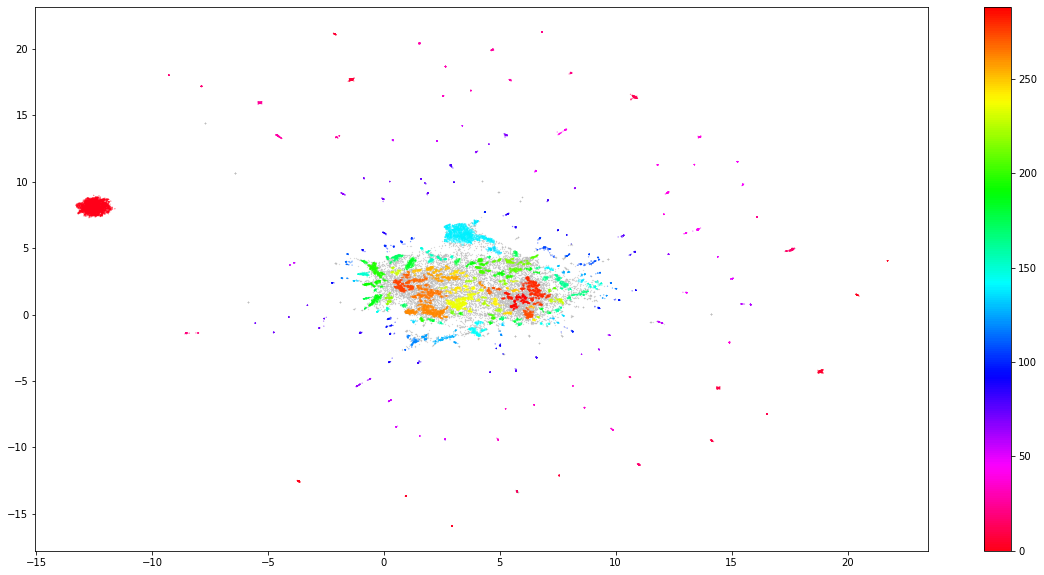

In [12]:
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_embeddings, columns=['x','y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20,10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [13]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [14]:
docs_per_topic

,Topic,Doc
0,-1,"it may be performed, distributed, reprod..."
1,0,Property o...
2,1,CONTINUED: ...
3,2,ANGELICA ...
4,3,SCRUM ...
...,...,...
285,284,look into it. eyes. ...
286,285,reckon you should take this ...
287,286,say blame you. Maybe we’...
288,287,We need him! ...


In [15]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [16]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/var/folders/sx/mxg316554p53ftfz37jrsvnr0000gn/T/ipykernel_89123/3267578824.py:5: RuntimeWarning: invalid value encountered in true_divide
  tf = np.divide(t.T, w)


In [17]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,10501
1,0,3017
140,139,1690
262,261,744
237,236,681
281,280,645
266,265,573
197,196,418
276,275,341
8,7,283


In [18]:
len(top_n_words)

290

In [21]:
index = [0,139,261,236,280,265,196,275]

In [22]:
for i in index:
    print("Topic #", i-1)
    print(top_n_words[i][:7])
    print()

Topic # -1
[('voice', 4.074291850089102), ('property', 2.9398293254119547), ('zzzzzzattt', 0.0), ('flagstone', 0.0), ('flags', 0.0), ('flagrante', 0.0), ('flagon', 0.0)]

Topic # 138
[('don', 0.32442812953929884), ('didn', 0.09764434485407508), ('know', 0.08663424203259773), ('won', 0.06512363300201511), ('doesn', 0.06493287122221547), ('just', 0.0562426322660515), ('like', 0.043044601708219346)]

Topic # 260
[('wrong', 0.09425183792206168), ('bad', 0.08241623094114925), ('crazy', 0.08133778084234682), ('dangerous', 0.06480132490636503), ('lost', 0.04636964613216445), ('just', 0.045272671449525285), ('mistake', 0.04055919127843888)]

Topic # 235
[('let', 0.20126487985060829), ('stop', 0.18858158009802636), ('away', 0.14134700548209647), ('shut', 0.10107592792899726), ('leave', 0.09919048244987558), ('left', 0.08159467235142162), ('gone', 0.08102409071988406)]

Topic # 279
[('know', 0.25595714170004547), ('just', 0.11707180850241744), ('did', 0.09275051606778487), ('got', 0.089998616073